__Military Losses in the Ongoing War in Urkraine__

_Collaborators: Rithwik Bhardwaj, Benjamin Coyne, Belen Desta, Amin Nazemzadeh_<br>
[Project Description](http://www.cs.umd.edu/class/spring2023/cmsc320-0101/files/tutorial.pdf)

__Introduction__<br>
This tutorial will show the reader how to work with data through the data science pipeline, from _Data Collection_, _Data Curation_, _Exploratory Analysis_, _Hypothesis Testing and Machine Learning_, and finally to _Interpretation_ of the results. This tutorial will be using data collected about the ongoing Russian invasion and war in Ukraine.<br>
Communication during warfare has always been of the utmost importance, especially in military intelligence and counter-intelligence. As warfare has become more complex, so too has the information that must be passed around. Additionally, while propaganda is an important part of warfare, it is important to be aware of what's really happening on the ground, in order to make the optimal decisions.<br>
With the increase in data complexity and massive influx of false or misleading data in the modern world, data processing and statistical techniques have become vital to make sense of the incoming data in order to use resources more efficiently and prevent unnecessary losses, not only of equipment but also of life.

The steps of the data science pipeline will be covered as follows:
1. [Data Collection](#DataCollection)
2. [Data Curation, Parsing, and Management](#Curation)
3. [Exploratory Data Analysis](#Analysis)
4. [Hypothesis Testing and Machine Learning](#Learning)
5. [Interpretation](#Interpretation)

__Imports__<br>
Before we get started, we will be importing a few libraries. Most functionality we will want has already been written, and so rather than trying to reinvent the wheel so to speak, we will be importing the resources that we will be using , allowing us to focus on the data science.

In [28]:
# hide warnings when running
import warnings
warnings.filterwarnings('ignore')

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy import NaN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

<a id="DataCollection"></a>
__Data Collection__<br>
For this tutorial, we are using data collected on the current war in Ukraine, that has been made publicly available at [_2022 Russia Ukraine War_](https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war?select=russia_losses_equipment.csv) and [_2022 Russia Ukraine War, Losses, Oryx + Images_](https://www.kaggle.com/datasets/piterfm/2022-ukraine-russia-war-equipment-losses-oryx). These datasets contain statistics on the type and quantity of Ukrainian and Russian equipment/personnel losses staring Feb 24, 2022 (The day of the full scale invasion).<br>
In order to access the data, you need to click the download button in the top right corner and extract the content. Create a folder in your working directory called "data" and move the file into the data folder.
- losses_russia.csv
- losses_ukraine.csv
- russia_losses_equipment.csv
- russia_losses_personnel.csv

<a id="Curation"></a>
__Data Curation, Parsing, and Management__<br>
Our first step is to read the datasets in our data folder and get a good idea of how our dataset is ordered. Then we need to clean up our data by removing unneeded information and filling in missing values, in order to allow ourselves to more easily operate on it.<br>
When we get our dataframes, it is important that we give them clear and descriptive names, to prevent confusion down the line.

Dataset 1: _Russian Equipment Loss per Day split into category_

First we need to import and get an initial look at the dataset to make sure that we know what format the data is in. We could look at the full dataset, but we only need a general idea of the shape, so looking at a few rows is enough.

In [29]:
# Read the cvs into a pandas DataFrame
df_RU_equipment = pd.read_csv("data/russia_losses_equipment.csv")

# print out first two rows
df_RU_equipment.head(2)

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN


It is important to double check the data type to ensure that our numberical data isn't being held in strings.

In [30]:
print(df_RU_equipment["aircraft"].dtype)

int64


Next, we must clean the data so its usable.

In [31]:
# reset DataFrame to avoid problems with repeated use of diff command below
df_RU_equipment_daily = pd.read_csv("data/russia_losses_equipment.csv")

# Convert the date to standardized datetime format
df_RU_equipment_daily['date'] = pd.to_datetime(df_RU_equipment['date'])

# Reorder the columns for ease of viewing
df_RU_equipment_daily = df_RU_equipment_daily.set_index(['date', 'day', 'greatest losses direction'])


# Change data to per day losses instead of cumulative loss and fill all NA with zero
df_RU_equipment_daily = df_RU_equipment_daily.diff().fillna(df_RU_equipment_daily).fillna(0).astype(int).reset_index()

# Drop greatest loss direction since inconsistent
df_RU_equipment_daily = df_RU_equipment_daily.drop(columns=['greatest losses direction'])

# drop columns since stopped being updated/merged with other columns 
df_RU_equipment_daily = df_RU_equipment_daily.drop(columns=['military auto', 'fuel tank', 'mobile SRBM system'])

# Display cleaned dataset
df_RU_equipment_daily.tail(10)

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles
399,2023-03-31,401,0,0,5,3,4,0,9,0,0,3,3,0
400,2023-04-01,402,0,0,1,4,8,1,0,0,1,2,7,0
401,2023-04-02,403,0,0,2,5,4,0,1,0,0,0,9,0
402,2023-04-03,404,0,0,1,7,7,0,13,0,1,2,16,0
403,2023-04-04,405,0,0,8,6,3,1,15,0,0,0,9,0
404,2023-04-05,406,0,0,2,6,10,4,6,0,0,1,11,0
405,2023-04-06,407,0,1,2,8,7,0,4,0,1,3,1,0
406,2023-04-07,408,0,0,2,3,8,1,4,0,0,2,13,0
407,2023-04-08,409,1,0,3,4,5,0,7,0,1,0,12,0
408,2023-04-09,410,0,0,0,4,13,0,14,0,0,5,3,0


Now that we have cleaned the DataFrame we need to get a overview of the our dataset.
We can remove some parts of the summary, as in this case the values are meaningless.


In [32]:
# Create some summary statistics for Russian equipment losses
df_RU_equipment_daily_summary = df_RU_equipment_daily.describe()

# Drop the "day" column - summary statistics are meaningless here
df_RU_equipment_daily_summary.drop(["day"], axis=1, inplace=True)

# Drop the "count" column - already know we have 1 entry for each day
df_RU_equipment_daily_summary.drop(["count"], axis=0, inplace=True)

# Return and display the summary statistics
df_RU_equipment_daily_summary

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles
mean,0.750611,0.713936,8.889976,17.173594,6.699267,1.303178,5.652812,0.044010,0.689487,0.755501,13.696822,2.227384
std,1.760516,1.890074,8.267591,29.222636,6.193373,2.127323,6.677204,0.238499,1.169008,1.232276,88.772987,9.664197
min,0.000000,0.000000,0.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,7.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,7.000000,12.000000,5.000000,0.000000,4.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,1.000000,1.000000,13.000000,22.000000,9.000000,2.000000,8.000000,0.000000,1.000000,1.000000,14.000000,0.000000
max,17.000000,20.000000,80.000000,516.000000,49.000000,17.000000,53.000000,2.000000,8.000000,10.000000,1796.000000,84.000000


Dataset 2: _Russian Personnel Loss per Day_

Again, we need to import and get an initial look at the dataset.

In [33]:
# Read the data from the appropriate csv
df_RU_personnel = pd.read_csv("data/russia_losses_personnel.csv")

# print out first two rows
df_RU_personnel.head(2)

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0


Check the datatype of the numeric column to see if we need to cast.

In [34]:
print(df_RU_personnel["personnel"].dtype)

int64


Now we clean the data and remove unnecessary columns.

In [35]:
# reset DataFrame to avoid problems with repeated use of diff command below
df_RU_personnel = pd.read_csv("data/russia_losses_personnel.csv")

# Convert the provided dates to a standard datetime format
df_RU_personnel['date'] = pd.to_datetime(df_RU_personnel['date'])

# Reorder the columns to ease viewing
df_RU_personnel = df_RU_personnel.set_index(['date', 'day', 'personnel*'])

# Change data to per day losses instead of cumulative loss and fill all NA with zero
df_RU_personnel = df_RU_personnel.diff().fillna(df_RU_personnel).fillna(0).astype(int).reset_index()

# drop columns since stopped being updated/merged with other columns 
df_RU_personnel = df_RU_personnel.drop(columns=['POW'])

# drop personnel* since it is unneeded information 
df_RU_personnel = df_RU_personnel.drop(columns=['personnel*'])

# Display part of the data
df_RU_personnel.tail(10)

,date,day,personnel
399,2023-03-31,401,460
400,2023-04-01,402,630
401,2023-04-02,403,560
402,2023-04-03,404,610
403,2023-04-04,405,530
404,2023-04-05,406,550
405,2023-04-06,407,390
406,2023-04-07,408,480
407,2023-04-08,409,570
408,2023-04-09,410,470


Now that we have cleaned the DataFrame we need to get a overview of the  dataset.

In [36]:
# Create some summary statistics for Russian personnel losses
df_RU_personnel_summary = df_RU_personnel.describe()

# Drop the day and count columns - as said before these are meaningless in this context
df_RU_personnel_summary.drop(["day"], axis=1, inplace=True)
df_RU_personnel_summary.drop(["count"], axis=0, inplace=True)

# Show the summary
df_RU_personnel_summary

,personnel
mean,435.574572
std,322.984140
min,0.000000
25%,200.000000
50%,370.000000
75%,620.000000
max,3160.000000


Dataset 3: _Visually Confirmed Ukrainian Losses_

As before, we can import the dataset and check the format.

In [37]:
# Read the data from the cvs
df_UA_total_vis = pd.read_csv("data/losses_ukraine.csv")

# Display part of the data
df_UA_total_vis.tail(5)

,equipment,model,sub_model,manufacturer,losses_total,Unnamed: 5,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
285,"Trucks, Vehicles and Jeeps",Peugeot P4,NaN,France,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
286,"Trucks, Vehicles and Jeeps",Unknown tanker,NaN,Ukraine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
287,"Trucks, Vehicles and Jeeps",Unknown truck,NaN,Ukraine,65,NaN,NaN,NaN,4.0,NaN,2.0,1.0,NaN,NaN,58.0,NaN,NaN,NaN
288,"Trucks, Vehicles and Jeeps",Unknown truck,with ZU-23 AA gun,Ukraine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
289,"Trucks, Vehicles and Jeeps",Unknown vehicle,NaN,Ukraine,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN


Check datatype.

In [38]:
print(df_UA_total_vis["losses_total"].dtype)

int64


Next, we need to clean the data by removing unnecessary columns. Additionally, since the granularity of the data is not required, we can group it by equipment type to provide useful statistics that will be easier to work with going forward.

In [39]:
# Breakdown of visually confirmed Ukrainian losses grouped by equipment type
df_UA_total_vis_grouped = df_UA_total_vis.groupby(['equipment']).sum(numeric_only=True)

# Take the sum of the values, and convert to type int from float
df_UA_total_vis_grouped = df_UA_total_vis_grouped.astype(int)

# Drop empty column
df_UA_total_vis_grouped.drop(["Unnamed: 5"], axis=1, inplace=True)

# Display the grouped data
df_UA_total_vis_grouped.head(5)

,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
equipment,,,,,,,,,,,,,
Aircraft,57,0,0,1,0,0,0,0,1,55,0,0,0
Anti-Aircraft Guns,4,0,0,4,0,0,0,0,0,0,0,0,0
Armoured Fighting Vehicles,260,4,0,77,0,3,1,1,0,174,0,0,0
Armoured Personnel Carriers,223,3,0,81,0,10,5,3,0,121,0,0,0
Artillery Support Vehicles And Equipment,22,0,0,12,0,0,0,0,0,10,0,0,0


Now that we have cleaned and grouped the data we can get some summary statistics.

In [40]:
# Create some summary statistics for Ukraine equipment losses
df_UA_equipment_vis_summary = df_UA_total_vis_grouped.describe()

# Drop the "count" column - already know we have 1 entry for each category
df_UA_equipment_vis_summary.drop(["count"], axis=0, inplace=True)

# Return and display the summary statistics
df_UA_equipment_vis_summary

,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
mean,121.333333,2.041667,0.416667,34.166667,0.458333,5.625000,1.000000,1.708333,0.041667,75.625000,0.041667,0.166667,0.041667
std,158.913886,4.515473,1.839581,45.671480,1.718927,7.482225,2.226325,3.329436,0.204124,101.707942,0.204124,0.816497,0.204124
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.750000,0.000000,0.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,9.500000,0.000000,0.000000,0.000000
50%,46.000000,0.000000,0.000000,11.500000,0.000000,2.000000,0.000000,0.500000,0.000000,28.000000,0.000000,0.000000,0.000000
75%,138.250000,1.500000,0.000000,40.250000,0.000000,10.500000,1.000000,1.000000,0.000000,87.250000,0.000000,0.000000,0.000000
max,513.000000,21.000000,9.000000,149.000000,8.000000,27.000000,9.000000,12.000000,1.000000,335.000000,1.000000,4.000000,1.000000


Dataset 4: _Visually Confirmed Russian Losses_

Now we can import and get an initial look at the last dataset.

In [41]:
# Read the file into dataframe
df_RU_total_vis = pd.read_csv("data/losses_russia.csv")

# Display part of the data
df_RU_total_vis.tail(2)

,equipment,model,sub_model,manufacturer,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,destroyed in a non-combat related incident,sunk
336,"Trucks, Vehicles and Jeeps",(Unknown) truck,NaN,Russia,262,1.0,NaN,10.0,1.0,NaN,7.0,2.0,NaN,NaN,241.0,NaN,NaN
337,"Trucks, Vehicles and Jeeps",(Unknown) vehicle,NaN,Russia,45,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,39.0,NaN,NaN


We can double check the datatype of the data again, to see if we need to cast.

In [42]:
print(df_RU_total_vis["losses_total"].dtype)

int64


Next, as with the last dataset, we need to group the data by equipment type to improve the usability of the dataset and remove any missing values that have been encoded as NaN. Additionally, because we know that the counts are recorded as whole values, we can convert the data to integers, rather than leaving them as floats.

In [43]:
# Breakdown of visually confirmed Russian losses grouped by equipment type
# We also want to make sure that we are only summing the numeric data
df_RU_total_vis_grouped = df_RU_total_vis.groupby(['equipment']).sum(numeric_only=True)

# Take the sum of the values, and convert to type int from float
df_RU_total_vis_grouped = df_RU_total_vis_grouped.astype(int)

# Display the grouped data
df_RU_total_vis_grouped.tail()

,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,destroyed in a non-combat related incident,sunk
equipment,,,,,,,,,,,,,
Surface-To-Air Missile Systems,92,4,2,20,0,0,3,1,3,0,59,0,0
Tanks,1673,37,11,485,4,5,74,26,56,0,975,0,0
Towed Artillery,164,5,0,85,0,0,6,0,8,0,59,0,0
"Trucks, Vehicles and Jeeps",2256,40,0,483,1,0,35,9,61,0,1627,0,0
Unmanned Combat Aerial Vehicles,7,0,0,1,0,0,0,0,0,0,6,0,0


In [44]:
# Create some summary statistics for Russian equipment losses
df_RU_equipment_vis_summary = df_RU_total_vis_grouped.describe()

# Drop the "count" column - already know we have 1 entry for each category
df_RU_equipment_vis_summary.drop(["count"], axis=0, inplace=True)

# Return and display the summary statistics
df_RU_equipment_vis_summary

,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,destroyed in a non-combat related incident,sunk
mean,375.916667,9.583333,1.208333,105.000000,0.458333,0.333333,9.958333,3.333333,9.666667,0.125000,235.625000,0.50000,0.041667
std,645.112253,16.314615,2.466809,163.482481,0.931533,1.167184,19.004528,7.938167,17.914450,0.612372,429.187788,1.86501,0.204124
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,0.000000
25%,33.500000,0.000000,0.000000,8.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.750000,0.00000,0.000000
50%,128.000000,2.000000,0.000000,44.000000,0.000000,0.000000,3.500000,0.000000,2.000000,0.000000,59.000000,0.00000,0.000000
75%,275.000000,6.500000,1.250000,94.250000,1.000000,0.000000,7.000000,1.000000,8.000000,0.000000,148.500000,0.00000,0.000000
max,2256.000000,60.000000,11.000000,541.000000,4.000000,5.000000,74.000000,30.000000,61.000000,3.000000,1627.000000,9.00000,1.000000


<a id="Analysis"></a>
__Exploratory Data Analysis__<br>
In this section, we will be using the dataframes that we operated on in the last section to look at what's going on more broadly with the data. This is where we will start to get an idea of what's happening in the war, and where we'll be able to start drawing some conclusions based on visible trends.

First, we'll make a chart to compare the equipment losses of each country. Here, we used an alpha value of 0.5 so that we could see where the values on the chart overlap.

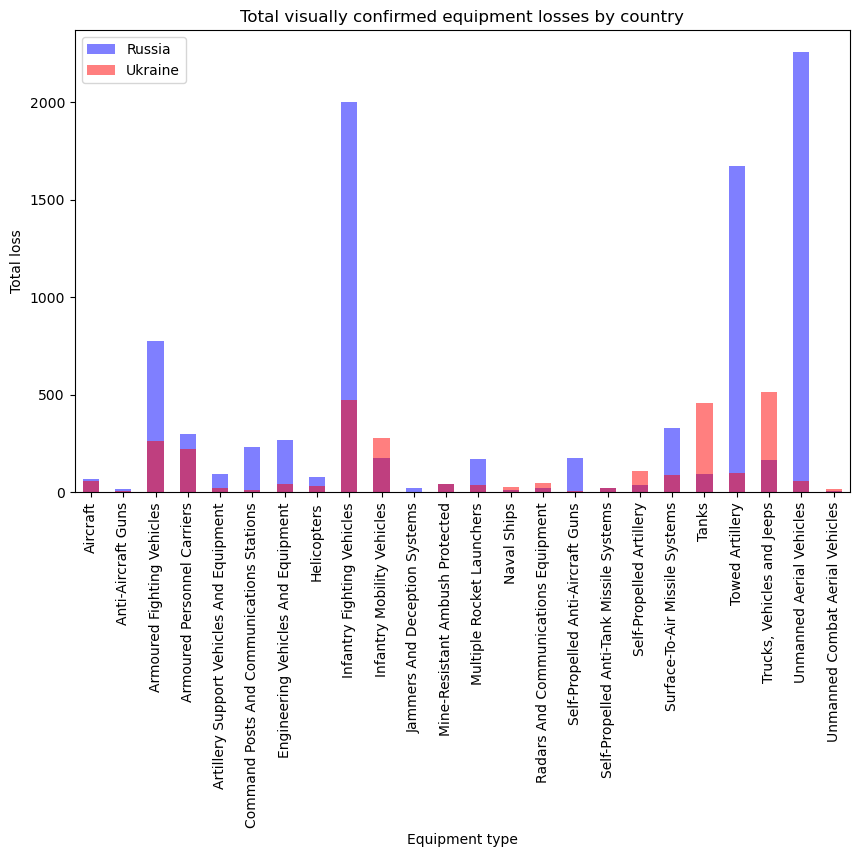

In [45]:
# We'll create a new plot with the data from the relevant dataset
ax = df_RU_total_vis_grouped['losses_total'].plot(kind='bar', color='blue', alpha=0.5, label='Russia')
# Next, we'll get the data from another dataset and plot it on the chart alongside the previous data
df_UA_total_vis_grouped['losses_total'].plot(kind='bar', color='red', alpha=0.5, label='Ukraine', ax=ax)

# Now we'll set the title to identify the chart
plt.title('Total visually confirmed equipment losses by country')
# And the axis labels to identify the variables beign plotted
plt.xlabel('Equipment type')
plt.ylabel('Total loss')

# increase size of plot
plt.gcf().set_size_inches(10, 6)
# Get a legend on the plot so we can see what's what
plt.legend()
# And finally we'll display the plot
plt.show()

Next, we can make a couple more charts to look at the equipment status for both Russia and Ukraine. Here, rather than plotting all the data on a single chart, we'll make two charts, one for Russian equipment, and one for Ukrainian equipment to make visualization a bit easier.<br>
We'll also be abbreviating "Visually confirmed" to "VisCon" to declutter the plot titles.

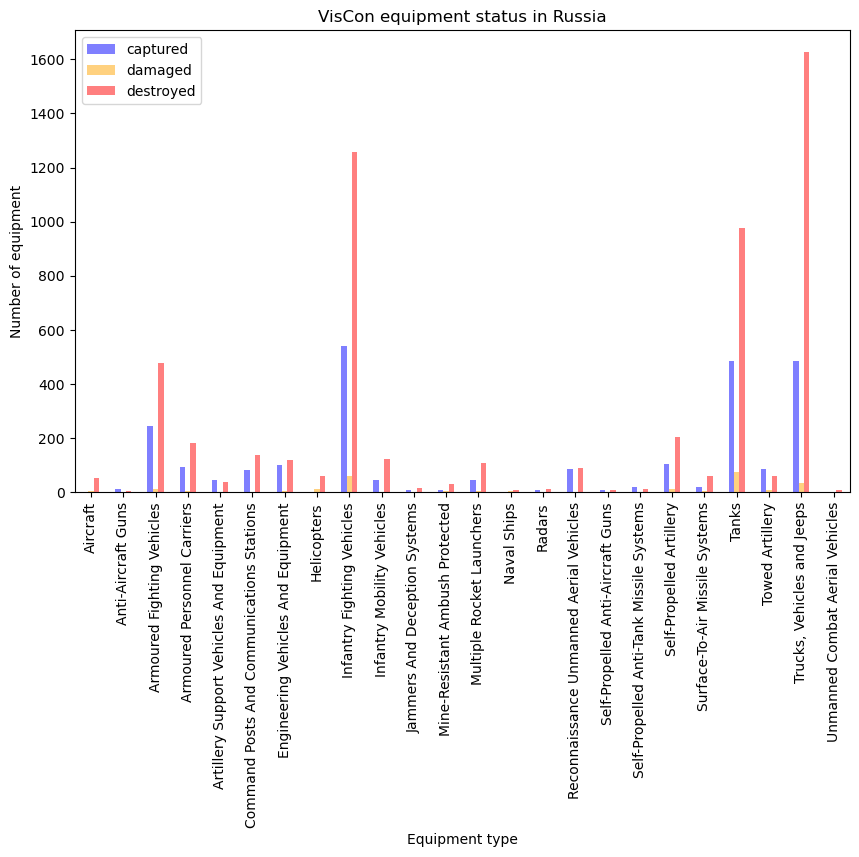

In [46]:
# We'll group our data in the desired manner, then plot it
df_RU_total_vis_grouped[['captured', 'damaged', 'destroyed']].plot(kind='bar', stacked=False, alpha=0.5, color=['blue', 'orange', 'red'])
# Set the title and labels so that we know which plot is which
plt.title('VisCon equipment status in Russia')
plt.xlabel('Equipment type')
plt.ylabel('Number of equipment')
# increase size of plot
plt.gcf().set_size_inches(10, 6)
# And display the first plot
plt.show()

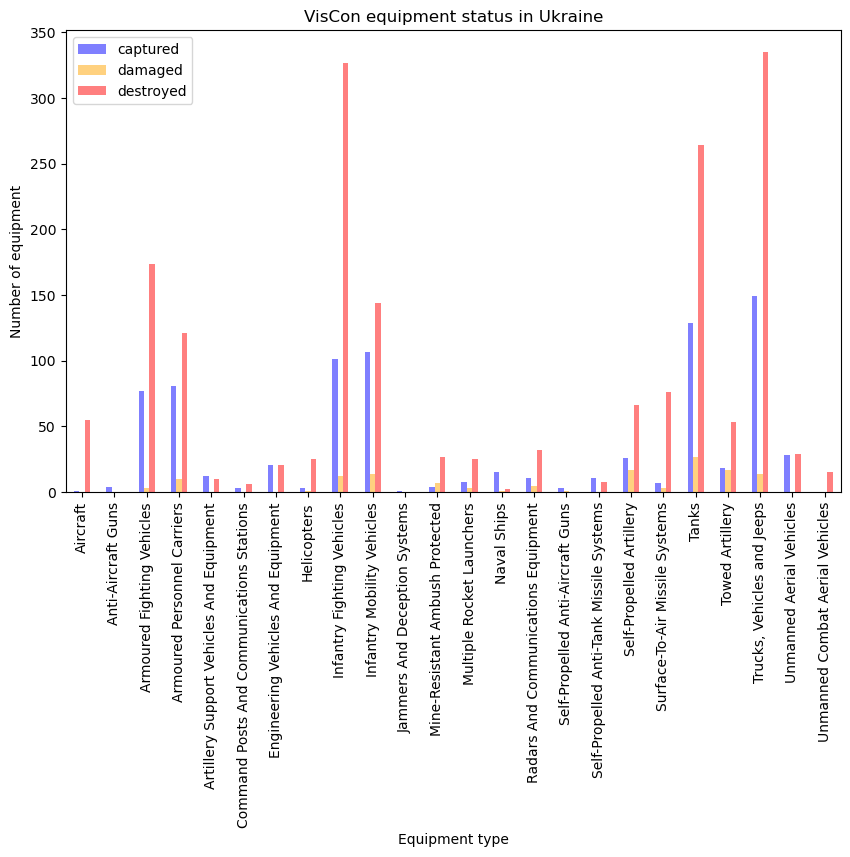

In [47]:
# Now we'll plot the second set of data in the same manner
df_UA_total_vis_grouped[['captured', 'damaged', 'destroyed']].plot(kind='bar', stacked=False, alpha=0.5, color=['blue', 'orange', 'red'])
# Again we need to set the title and axis labels
plt.title('VisCon equipment status in Ukraine')
plt.xlabel('Equipment type')
plt.ylabel('Number of equipment')
# increase size of plot
plt.gcf().set_size_inches(10, 6)
# And display the second plot
plt.show()

Looking at the charts we've made so far, we can see that Russian seems to be suffering greater equipment losses than Ukraine. Let's dive a bit deeper to see if we can figure out a bit more about what's happening.

One thing we can try is standardizing the data, by subtracting the mean and dividing by the standard devaition, both of which we have in the summary datasets.

In [48]:
# Standardize the Ukrainian losses
df_UA_total_grouped_vis_standardized = (df_UA_total_vis_grouped["losses_total"] - df_UA_equipment_vis_summary["losses_total"]["mean"]) / df_UA_equipment_vis_summary["losses_total"]["std"]
df_UA_total_grouped_vis_standardized.head()

equipment
Aircraft                                   -0.404831
Anti-Aircraft Guns                         -0.738345
Armoured Fighting Vehicles                  0.872590
Armoured Personnel Carriers                 0.639759
Artillery Support Vehicles And Equipment   -0.625076
Name: losses_total, dtype: float64

In [49]:
# And then the russian losses
df_RU_total_grouped_vis_standardized = (df_RU_total_vis_grouped["losses_total"] - df_RU_equipment_vis_summary["losses_total"]["mean"]) / df_RU_equipment_vis_summary["losses_total"]["std"]
df_RU_total_grouped_vis_standardized.head()

equipment
Aircraft                                   -0.475757
Anti-Aircraft Guns                         -0.557913
Armoured Fighting Vehicles                  0.615526
Armoured Personnel Carriers                -0.123880
Artillery Support Vehicles And Equipment   -0.441654
Name: losses_total, dtype: float64

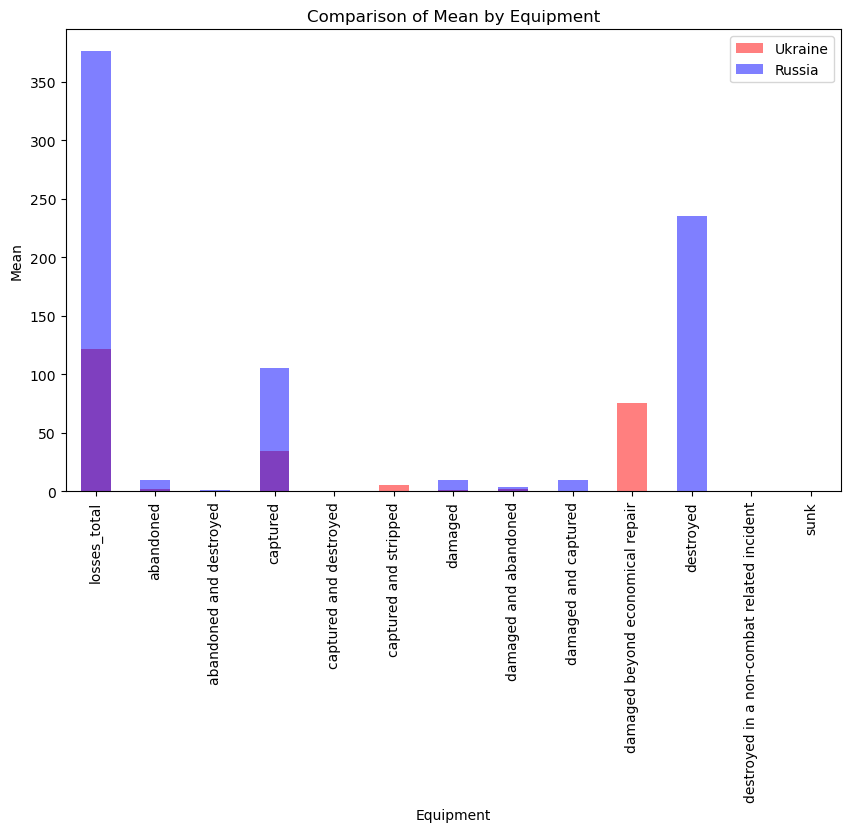

In [50]:
# Here, we'll get some mean values for the equipment summaries
# For Ukraine
UA_means = df_UA_equipment_vis_summary.loc['mean']
# And for Russia
RU_means = df_RU_equipment_vis_summary.loc['mean']

# Now we'll plot the means that we collected for both countries
ax = UA_means.plot(kind='bar' ,color='red', alpha=0.5, label='Ukraine')
RU_means.plot(kind='bar', color='blue', alpha=0.5, label='Russia')
# Set the title and labels again
plt.title('Comparison of Mean by Equipment')
plt.xlabel('Equipment')
plt.ylabel('Mean')
# increase size of plot
plt.gcf().set_size_inches(10, 6)
# Now we'll get a legend
plt.legend()
# And display the chart
plt.show()


Based on this graph, we can conclude a few things that can help us learn
more about the war. Even without knowing any prior knowledge about each 
country and their militaries, we can see that the Russia lost more
equipment in total, but captured more as well. This can indicate:
Russia is more likely to be the attacker with more military power,
since their military was able to capture the other country's equipments.  
In war, the attacker almost always loses more, because they are not in their 
element/territory. But another important thing to consider is, although Russia 
lost more in total number, percentage wise, this may not be necassarily true, 
since they have a larger military. One final important conclusion is, 
Ukraine was very successful at defending. This can be because of their 
military strategies, or because they are in their home country.

Next we can look at Russian personnel losses. Unfortunately, we do not have the same data for Ukraine.

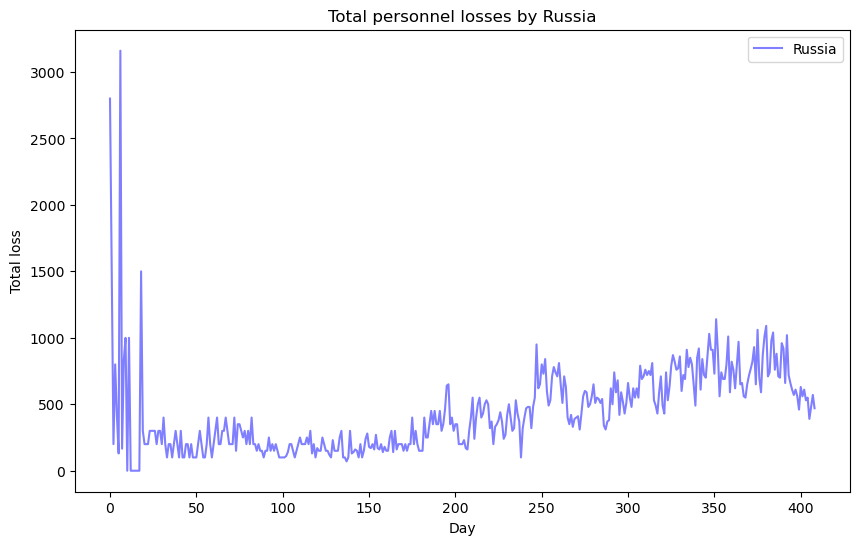

In [51]:
df_RU_personnel['personnel'].plot(kind='line', color='blue', alpha=0.5, label='Russia')

plt.title('Total personnel losses by Russia')
plt.xlabel('Day')
plt.ylabel('Total loss')
plt.legend()
# increase size of plot
plt.gcf().set_size_inches(10, 6)
plt.show()

Here we can see that Russia started out losing a lot of personnel at the start of the war, but over time they have adjusted their methods and reduced casualties, leaving the current number much closer to the mean.<br>
We can also look at the full total of equipment losses over time.

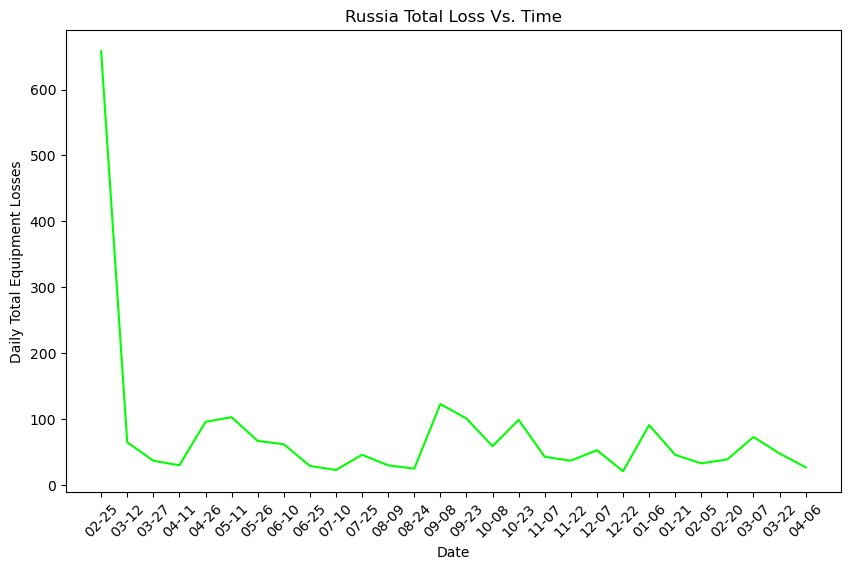

In [52]:
df_RU_equipment['total_eq_losses'] = df_RU_equipment_daily.iloc[:, 3:].sum(axis = 1)
# select the date and total_losses columns to the variable
df_RU_total_losses = df_RU_equipment.loc[:, ['date', 'total_eq_losses']]
fig, ax = plt.subplots(figsize=(10,6))
# plot the date vs total loss skipping every 15 to increase readability
ax.plot(df_RU_total_losses['date'][::15].apply(lambda x: x[5:]), df_RU_total_losses['total_eq_losses'][::15], color = 'lime')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Total Equipment Losses')
ax.set_title('Russia Total Loss Vs. Time')
# rotate xtick for readability
plt.xticks(rotation=45)
plt.show()

By looking at the slope here, we can see that Russia was rapidly losing equipment at the begining of the war, but as with their personnel, they adjusted theor methods and reduced the amount of equipment they lost each day.

<a id="Learning"></a>
__Hypothesis Testing and Machine Learning__<br>
After examining the graphs above, we can form a hypothesis that the amount of personnel and equipment losses for 
Russia has decreased as time has gone on since the beginning of the conflict. To test this hypothesis, we will treat each date as an independent
variable and total personnel and equipment loss as dependent variables. Linear regression can be used to model the 
relationship between these two variables. However, it is crucial to choose continuous variables for both the dependent and 
independent variables, such as time or date for the independent variable and total equipment or personnel loss for the
dependent variable. It is important to avoid using equipment names or other string values as independent or dependent
variables.

First, let's examine the linear regression for Total Personnel Loss.

In [53]:
X = df_RU_personnel.loc[:, ['date', 'personnel']]
# Convert the date column to datetime
X['date'] = pd.to_datetime(X['date'])
# Convert the datetime to number value
X['date'] = (X['date'] - X['date'].min()).dt.days
# target variable
y = X['personnel']
# drop the total_losses column from X
X.drop('personnel', axis = 1, inplace = True)
# Create and fit the model
model = LinearRegression()
model.fit(X, y)
# print the coefficients
print('Intercept: ', model.intercept_)
print('Slop: ', model.coef_[0])

Intercept:  153.6923251237401
Slop:  1.3817757206048984


In [54]:
# Convert the date to datetime format
df_RU_personnel['date'] = pd.to_datetime(df_RU_personnel['date'])
# Fit linear regression model
x = df_RU_personnel['date'].apply(lambda x: x.timestamp()).values.reshape(-1,1)
Y = df_RU_personnel['personnel'].values.reshape(-1,1)
reg = LinearRegression().fit(x, Y)
# Perform hypothesis test on slope coefficient
x = sm.add_constant(x)
model = sm.OLS(Y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     139.9
Date:                Wed, 10 May 2023   Prob (F-statistic):           6.07e-28
Time:                        21:29:51   Log-Likelihood:                -2882.5
No. Observations:                 409   AIC:                             5769.
Df Residuals:                     407   BIC:                             5777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.617e+04   2249.368    -11.633      0.0

Let's examine linear regression for Total Equipment Loss.

In [55]:
X2 = df_RU_total_losses.loc[:, ['date', 'total_eq_losses']]
# Convert the date column to datetime
X2['date'] = pd.to_datetime(X2['date'])
# Convert the datetime to number value
X2['date'] = (X2['date'] - X2['date'].min()).dt.days
# target variable
y2 = X2['total_eq_losses']
# drop the total_losses column from X
X2.drop('total_eq_losses', axis = 1, inplace = True)
# Create and fit the model
model = LinearRegression()
model.fit(X2, y2)
# print the coefficients
print('Intercept: ', model.intercept_)
print('Slop: ', model.coef_[0])

Intercept:  82.7315284155287
Slop:  -0.12198805218312526


In [56]:
# Convert the date to datetime format
df_RU_total_losses['date'] = pd.to_datetime(df_RU_total_losses['date'])
# Fit linear regression model
x2 = df_RU_total_losses['date'].apply(lambda x2: x2.timestamp()).values.reshape(-1,1)
Y2 = df_RU_total_losses['total_eq_losses'].values.reshape(-1,1)
reg = LinearRegression().fit(x2, Y2)
# Perform hypothesis test on slope coefficient
x2 = sm.add_constant(x2)
model = sm.OLS(Y2, x2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     8.110
Date:                Wed, 10 May 2023   Prob (F-statistic):            0.00462
Time:                        21:29:52   Log-Likelihood:                -2472.1
No. Observations:                 409   AIC:                             4948.
Df Residuals:                     407   BIC:                             4956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2406.3599    824.672      2.918      0.0

To predict equipment losses in Russia based on date value, we will utilize Random Forest Regression. 
To determine the number of decision trees used in the model, we'll set the hyperparameter n_estimators to 100. 
This is a common and effective default value for many datasets. Additionally, we'll set the random_state parameter to 42,
which ensures that the same random sequence is generated each time the code is run, resulting in more reproducible results.

In [57]:
# Select the columns for regression
x3 = df_RU_total_losses.loc[:, ['date']]
# Convert the date column to datetime
x3['date']=pd.to_datetime(x3['date'])
# Convert the datetime to numberic value
x3['date'] = (x3['date'] - x3['date'].min()).dt.days
# Create the target variable 
y3 = df_RU_total_losses['total_eq_losses']
# Split the data into training and testing sets
x_tr, x_test, y_tr, y_test = train_test_split( x3, y3, test_size = 0.2 , random_state = 42)
# Create the model and fit it to the training data
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(x_tr, y_tr)
# Make predictions on the testing data
y_predictions = model.predict(x_test)
# Calculate the root mean square error for the predictions
root_mean_sq_er = mean_squared_error(y_test, y_predictions, squared = False)
print("The root mean square error is: ", root_mean_sq_er)

The root mean square error is:  51.56134996056734


To evaluate the accuracy of the model in predicting equipment losses based on the given date, we use the root mean square
error value. This value indicates the average difference between the predicted and actual equipment losses for the testing 
data. Our root mean square error value explains that, on average, our predictions are off by the value of the root mean square error in total equipment losses.

Prediction of the number of equipment losses for Russia at a specific date

In [58]:
# Select the columns that we will use for regression
x5 =  df_RU_total_losses.loc[:, ['date','total_eq_losses']]
# Convert the date column to datetime
x5['date'] = pd.to_datetime(x5['date'])
# Conver the datetime value to numeric value
x5['date'] = (x5['date'] - x5['date'].min()).dt.days
# Create target variable
y5 = x5['total_eq_losses']
# Drop the total_eq_losses column from x5
x5.drop('total_eq_losses', axis = 1 , inplace = True)
# Create and fit the model
model = LinearRegression()
model.fit(x5, y5)
#Predict the amount of equipment losses for Russia at future date
future_date = '2023-05-20'
future_date_df = pd.DataFrame({'date': [future_date]})

future_date_df['date'] = pd.to_datetime(future_date_df['date'])
future_date_df['date'] = (future_date_df['date'] - pd.Timestamp (x5['date'].min())).dt.days

#x_pr = future_date_df['date']
prediction_losses = model.predict(future_date_df)
print("Predicted equipment losses for Russia on ", future_date, "is", prediction_losses[0])

Predicted equipment losses for Russia on  2023-05-20 is -2295.6695249988643


The value of the predicted equipment losses for Russia is a negative number, indicating that as time has gone on, Russia has gotten better at preventing losses, after their major losses at the beginning of the war.<br>
It should also be noted that this model is not broadly generalizable, and may not be suitable for predicting losses beyond the range of the training data. This may be due to external factors such as the type and manufacturer of equipment used, as well as the amount of equipment used. As a result, making predictions using this data may be challenging since equipment losses have not shown significant growth or decline since the war began.

This isn't the only analysis we can do. We can also perform an analysis to relate daily equipment and personnel losses for Russia.<br>
Here, we hypothesise that daily equipment losses are positively related to daily personnel losses, such that as equipment losses rise, so to will personnel losses. In theory, this should be due to the use of personnel and equipment in the same areas, and that equipment losses will involve some loss of the personnel operating the equipment. We additionally hypothesise that the different types of equipment will be differently related to the personnel loss, due to the different ways that the equipment is crewed and operated, along with the different levels of risk accosiated with the different types of equipment.<br>
Unfortunately, we are unable to perform this same analysis for Ukraine, as the data that we are using does not provide day-by-day data.<br> 

The first step here will be to find the total daily equipment losses, being the sum of counts for each type of equipment for each day.

In [59]:
# Make a new copy of the dataframe with the equipment information
df_RU_equipment_daily_totalled = df_RU_equipment_daily.copy()

# Next we use the sum() function, adding across columns, only on numeric data (skipping the date)
# We also need to remember to drop the "day" column, so that it doesn't get added to the sum
df_RU_equipment_daily_totalled["total_equip_loss"] = df_RU_equipment_daily_totalled.drop("day", axis=1).sum(axis=1, numeric_only=True)

# Now we can return out new dataframe to make sure everything worked like we wanted
df_RU_equipment_daily_totalled.tail(5)

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,total_equip_loss
404,2023-04-05,406,0,0,2,6,10,4,6,0,0,1,11,0,40
405,2023-04-06,407,0,1,2,8,7,0,4,0,1,3,1,0,27
406,2023-04-07,408,0,0,2,3,8,1,4,0,0,2,13,0,33
407,2023-04-08,409,1,0,3,4,5,0,7,0,1,0,12,0,33
408,2023-04-09,410,0,0,0,4,13,0,14,0,0,5,3,0,39


Next, we'll merge the daily personnel and equipment loss dataframes, in order to get a single dataframe that we can more easily use to create models. We can join the dataframes on the date, using an inner join so that we only end up with entries for dates that had information on both equipment and personnel losses.

In [60]:
# We first need to reindex the dataframes by the date so that they can be joined
equipment_reindexed = df_RU_equipment_daily_totalled.set_index("date")
personnel_reindexed = df_RU_personnel.set_index("date")

# Now we join the daily equipment and personnel loss dataframes on the date
# Because the dataframes have the common "day" column as well, we need to specify some suffixes for the columns
daily_RU_losses = equipment_reindexed.join(personnel_reindexed, on="date", how="inner", lsuffix='_equip', rsuffix='_person')

# Now we can drop the day columns, since we won't be using them
daily_RU_losses.drop(["day_equip", "day_person"], axis=1, inplace=True)

# And now return and check the new dataframe
daily_RU_losses.tail(5)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,total_equip_loss,personnel
date,,,,,,,,,,,,,,
2023-04-05,0,0,2,6,10,4,6,0,0,1,11,0,40,550
2023-04-06,0,1,2,8,7,0,4,0,1,3,1,0,27,390
2023-04-07,0,0,2,3,8,1,4,0,0,2,13,0,33,480
2023-04-08,1,0,3,4,5,0,7,0,1,0,12,0,33,570
2023-04-09,0,0,0,4,13,0,14,0,0,5,3,0,39,470


Let's make a scatter plot to visualize the data, before we make a model.

Text(0, 0.5, 'Equipment Loss')

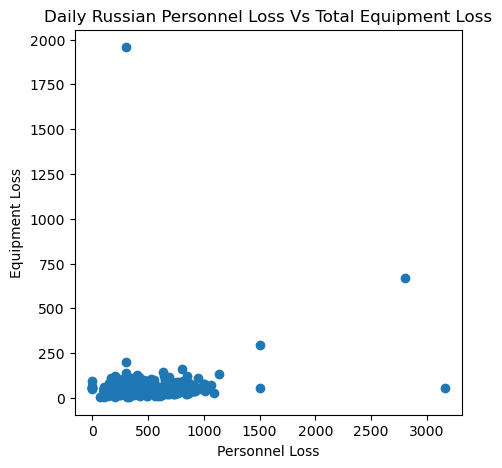

In [61]:
# First we'll create a new subplot to use
scatter0, axs = plt.subplots(1, figsize=(5,5))

# Then we'll plot the data we want
axs.scatter(daily_RU_losses["personnel"], daily_RU_losses["total_equip_loss"])

# Now we give it a descriptive title
axs.set_title("Daily Russian Personnel Loss Vs Total Equipment Loss")
# And set the axis labels
axs.set_xlabel("Personnel Loss")
axs.set_ylabel("Equipment Loss")

From the plot we just made, there isn't a clear relationship, so we'll need to find a new model to see if we can find anything.

Now we'll start working on our model to see if there is a relationship between equipment losses and personnel losses that we couldn't see on the chart.<br>
For our first model, we'll use Ordinary Least Squares to find a relationship between the total equipment losses and personnel losses

In [62]:
# Create a new ols model that predicts personnel loss based on equipment loss
regResults_totals = smf.ols(formula="personnel ~ total_equip_loss", data=daily_RU_losses).fit()
print(regResults_totals.summary())

                            OLS Regression Results                            
Dep. Variable:              personnel   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.565
Date:                Wed, 10 May 2023   Prob (F-statistic):             0.0108
Time:                        21:29:54   Log-Likelihood:                -2939.6
No. Observations:                 409   AIC:                             5883.
Df Residuals:                     407   BIC:                             5891.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          412.5385     18.234  

Based on the summary above, we can conclude that there isn't a statistically significant relationship between total equipment loss and personnel loss, as the P value for total_equipment_loss is greater than our desired significance level of 0.05.<br>
We can visualize how well this model fits (or doesn't fit, as the case seems to be) by plotting the residual values.

date
2023-04-05    121.736313
2023-04-06    -33.152989
2023-04-07     54.488227
2023-04-08    144.488227
2023-04-09     42.129443
dtype: float64


Text(0, 0.5, 'Prediction Residual Values')

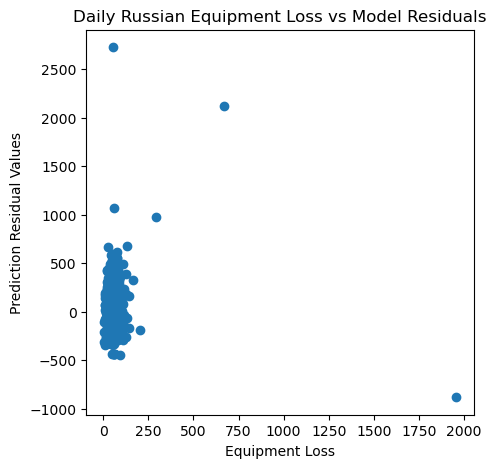

In [63]:
params = daily_RU_losses["total_equip_loss"]

# Get the predicted values for each day
predictions = regResults_totals.predict(exog=params)

# Calculate the residual values as the difference between the actual and prediced values
residuals = daily_RU_losses["personnel"] - predictions

print(residuals.tail())

# Create a new plot for the residuals
scatter0, axs = plt.subplots(1, figsize=(5,5))

axs.scatter(daily_RU_losses["total_equip_loss"], residuals)


# Now we give it a descriptive title
axs.set_title("Daily Russian Equipment Loss vs Model Residuals")
# And set the axis labels
axs.set_xlabel("Equipment Loss")
axs.set_ylabel("Prediction Residual Values")

In an ideal model, we would want the predicted values to be as close to the actual values as possible, meaning that the residuals would be close to 0. Here, we see a large spread of residuals, again showing that this model is not a good for for our data.<br>
At this point, our current hypothesis that equipment loss and personnel loss are related is not supported.<br>
However, we do still have other models that we can try, and so we'll next create a model that uses the losses of different types of equipment, rather than the total equipment loss.

In [64]:
# We first want to replace undesired characters in the column names with underscores so we can use them in the formula
daily_RU_losses_renamed = daily_RU_losses.copy()
daily_RU_losses_renamed.columns = daily_RU_losses.columns.str.replace(r"[- ]", "_")
#print(daily_RU_losses_renamed.tail(5))

# Create a new ols model that predicts personnel loss based on equipment loss
# aircraft + helicopter +	tank +	APC +	field artillery +	MRL +	drone +	naval ship +	anti-aircraft warfare +	special equipment +	vehicles and fuel tanks +	cruise missiles
regResults_sep = smf.ols(formula="personnel ~ aircraft + helicopter +	tank +	APC +	field_artillery +	MRL +	drone +	naval_ship +	anti_aircraft_warfare +	special_equipment +	vehicles_and_fuel_tanks +	cruise_missiles", data=daily_RU_losses_renamed).fit()
print(regResults_sep.summary())

                            OLS Regression Results                            
Dep. Variable:              personnel   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     6.653
Date:                Wed, 10 May 2023   Prob (F-statistic):           6.66e-11
Time:                        21:29:54   Log-Likelihood:                -2905.3
No. Observations:                 409   AIC:                             5837.
Df Residuals:                     396   BIC:                             5889.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

With this new model, we can see a much more detailed interaction between equipment loss and personnel loss, with many of the coefficients being significantly different from 0. An unexpected occurence here is that many of the coefficents are negative, suggesting that as equipment losses go up, personnel losses go up.<br>
It does need to be noted that the P values are significantly higher than 0.05, meaning that these relationships are not statistically significant, except for Armored Personnel Carriers (APCs).<br>
We can again plot the residuals to see if the model at least fits the data better than the last model.

date
2023-04-05    136.033160
2023-04-06   -104.676296
2023-04-07     48.648929
2023-04-08    198.441330
2023-04-09    -75.566796
dtype: float64


Text(0, 0.5, 'Prediction Residual Values')

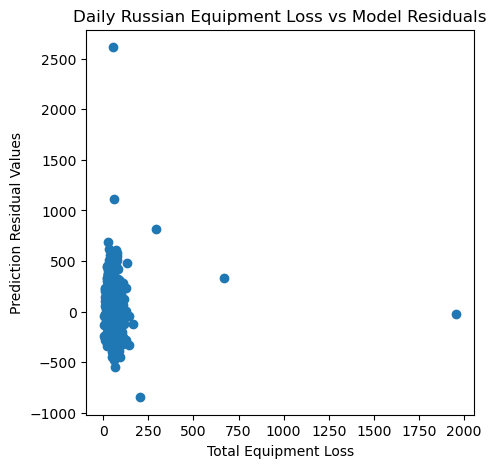

In [65]:
params = daily_RU_losses_renamed[["aircraft", "helicopter", "tank", "APC", "field_artillery", "MRL", "drone", "naval_ship", "anti_aircraft_warfare", "special_equipment", "vehicles_and_fuel_tanks", "cruise_missiles"]]

# Get the predicted values for each day
predictions = regResults_sep.predict(exog=params)

# Calculate the residual values as the difference between the actual and prediced values
residuals = daily_RU_losses["personnel"] - predictions

print(residuals.tail())

# Create a new plot for the residuals
scatter0, axs = plt.subplots(1, figsize=(5,5))

axs.scatter(daily_RU_losses["total_equip_loss"], residuals)

# Now we give it a descriptive title
axs.set_title("Daily Russian Equipment Loss vs Model Residuals")
# And set the axis labels
axs.set_xlabel("Total Equipment Loss")
axs.set_ylabel("Prediction Residual Values")

Here, we can see that, again, the residuals are spread away from 0, which is not what we would hope for from a well-fit model, showing that even seperating out the features does not seem to improve the predictions.<br>
This can be confirmed by directly comparing the F-statistics from the models.

In [66]:
print("Total Equipment Loss Model F-value:", regResults_totals.fvalue)
print("Indiv Equipment Loss Model F-value:", regResults_sep.fvalue)

Total Equipment Loss Model F-value: 6.564789488312548
Indiv Equipment Loss Model F-value: 6.653028811311421


With this, we can see that there isn't a significant improvement with either model.

While we were unable to confirm out hypotheses, we are still able to draw some conclusions from our models. Because there doesn't seem to be a significant relationship between equipment and personnel loss, Russian equipment can be targeted without contributing to a significant loss of life, which is valuable to know when planning attacks and picking targets. However, this does not hold for APCs, as this was the one type of equipment that did have a significant relationship with personnel loss, meaning that if the current objective is to inflict casualties (as is sometimes unavoidable in warfare), then APCs should be targeted.

<a id="Interpretation"></a>
__Interpretation and Final Thoughts__<br>
The final step in the data science pipeline is to make interpretations of your findings and draw conclusions. As we have looked at the data, we have come up with a few conclusions that have been particularly significant.<br>
Upon looking at the data gathered, a few surprising observations and conclusions can be gathered from the data. The first and most obvious one is that Russia, although often considered a global superpower, has suffered greater losses compared to Ukraine, especially of equipment. Russia initially lost a lot of personnel as well, but over time, far less people gave their lives, possibly due to a change of strategies or learning more about the new environment. A general rule that can be learned, which has also been observed in most recent wars is, the attacking country tend to lost more equipment and personnel, and our data verifies that as well. With that, a very important thing we can see is that Ukraine, a country not necassarily known for it's military might, has been defending against Russian attacks very successfully. A key learning here is that there are many other factors that cause a country to lose, other than just the numbers of their people or war devices.<br>
Another conclusion that can be drawn based on our constructed models is that it appears there is no significant correlation between personnel and equipment losses, and there is no direct relationship between the date and the number of losses for Russia. Predicting future losses can be challenging since external factors can impact the number of losses, making it difficult to rely solely on trained data. Knowing what leads to increased casualties and what doesn't is very valuable when considering strategies with regards to the human cost of the war.<br>

As we have seen, it is very important to thoroughly examine the data, both to support _and_ to reject any conclusions that we may draw. This becomes especially important with such a major event as the ongoing war in Ukraine - what happens now will have long-lasting ramifications that will forever change the global stage. The more information we are able to gather and interpret now will determine how well we are able to adjust to and deal with these changes, shaping future policy.